<a href="https://colab.research.google.com/github/souluran/Autoencoder_project/blob/master/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


In [ ]:
# Подгрузим python библиотеки
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import copy
from tqdm import tqdm, tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

# Vanilla Autoencoder (2 балла)

**Vanilla autoencoders**. The vanilla autoencoder, as proposed by Hinton, consists of only one hidden layer. The number of neurons in the hidden layer is less than the number of neurons in the input (or output) layer.

## Prepare the data


Не забудьте включите GPU accelarator перед запуском тренировки модели.
Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, and then re-execute this cell.

In [ ]:
!nvidia-smi

In [ ]:
if torch.cuda.is_available():
    print('CUDA is available. Training on GPU ...')
else:
    print('CUDA is not available! Training on CPU ...')

CUDA is available. Training on GPU ...


Поскольку в нашем коде могут использоваться генераторы случайных чисел, зададим для них начальное число, чтобы при каждом запуске кода получать похожий результат. Также включим детерменизм на GPU обработчике, что может сэкономить время, облегчая эксперименты, отладку и регрессионное тестирование.

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.random.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

При помощи функции, ниже, скачаем набор данных LWF с предварительной выравнивание изображений.

In [ ]:
from PIL import Image
from imageio import imread
import os

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img:np.array(Image.fromarray(img).resize((dimx,dimy))))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [ ]:
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = data.shape[3] # RGB
print("IMAGE_H:", IMAGE_H, "IMAGE_W:", IMAGE_W, "N_CHANNELS:", N_CHANNELS)

IMAGE_H: 45 IMAGE_W: 45 N_CHANNELS: 3


Разобъем выборку картинок на train и val:

In [ ]:
# приведем полученный массив данных к типу float32
data = np.array(data / 255, dtype='float32')

In [ ]:
TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE

In [ ]:
# разделим изображения на train и valid наборы
X_train = data[:TRAIN_SIZE]
X_val = data[TRAIN_SIZE:VAL_SIZE+TRAIN_SIZE]

Вспомогательная функцию, которая будет выводить n_row * n_col первых картинок в массиве images:

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

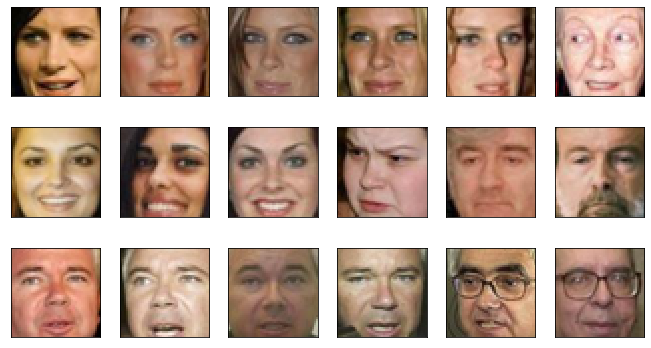

In [ ]:
plot_gallery(X_val[290:308], IMAGE_H, IMAGE_W)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [ ]:
print(type(X_train))

<class 'numpy.ndarray'>


In [ ]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

In [ ]:
print(X_train.type())

torch.FloatTensor


In [ ]:
X_train.shape

torch.Size([10000, 45, 45, 3])

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

### Simple architecture

Ниже представлена архитектура автоэнкодера, которая состоит из 6 полносвязанных слоев (FC) с нелинейными функциями активациями ReLU. BatchNorm1d используем для нормализации среднего и значения дисперсии во время обучения, чтобы восставноленные изображения выводились корректно и работало сэмплирование.

In [ ]:
# Автоэнкодер - простой c FC-слоями
class Autoencoder(nn.Module):
    def __init__(self, h_dim=3*45*45, z_dim=100):
        super(Autoencoder, self).__init__()
        self.name = "simple"
        # архитектура энкодера
        self.encoder = nn.Sequential(
            # encoder layer-1
            nn.Linear(h_dim, 1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            # encoder layer-2
            nn.Linear(1500, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            # encoder layer-3
            nn.Linear(1024, z_dim),
            nn.BatchNorm1d(z_dim),
            nn.ReLU()
        )
        # архитектура декодера
        self.decoder = nn.Sequential(
            # decoder layer-1
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            # decoder layer-2
            nn.Linear(1024, 1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            # decoder layer-3
            nn.Linear(1500, h_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        code = self.encode(x)
        reco = self.decode(code)
        return reco, code

### Convolution architecture

In [ ]:
# Автоэнкодер со сверточными слоями (CNN)
class Autoencoder_cnn(nn.Module):
    def __init__(self):
        super(Autoencoder_cnn, self).__init__()
        self.name = "cnn"
        # архитектура энкодера
        self.encoder = nn.Sequential(
            # encoder layer-1
            nn.Conv2d(3, 16, kernel_size=3, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # encoder layer-2
            nn.Conv2d(16, 8, kernel_size=3, stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # архитектура декодера
        self.decoder = nn.Sequential(
            # decoder layer-1
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=5, stride=2),
            # decoder layer-2
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=5, stride=2),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # для Conv2d слоя приводим тензор к виду [batch, channel, hight, weight]
        x = x.permute(0,3,1,2)
        code = self.encode(x)
        # print("code:", code.shape)
        reco = self.decode(code)
        # print("reco:", reco.shape)
        return reco, code

## Train Vanilla Autoencoder

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
# Training of model
def fit_epoch(model, train_loader, loss_fn, optimizer, input_size=3*45*45, is_conv=False):
    '''
    Обучение выбранной модели
      model        - модель автоэнкодера
      train_loader - тренировачный набор разбитый по batch в DataLoader
      loss_fn      - функция потерь
      optimizer    - функция оптимизации learning rate
      input_size   - кол-во признаков (C_size * H_size * W_size)
    '''
    model.train()
    running_loss = 0.0
    processed_data = 0
  
    for inputs in train_loader:
        if not is_conv:
            # приводим входной тензор к виду [batch, hight*weight*channel]
            inputs = inputs.view(-1, input_size)
        inputs = inputs.cuda()
        
        optimizer.zero_grad()

        recovered_code, latent_code = model(inputs)
        if not is_conv:
            # приводим входной тензор к виду [batch, hight*weight*channel]
            outputs = recovered_code.view(-1, input_size)
        else:
            # меняем измерения выходного тензора к виду [batch, hight, weight, channel]
            outputs = recovered_code.permute(0,2,3,1)

        loss = loss_fn(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    return train_loss

# Loss estimation
def eval_epoch(model, val_loader, loss_fn, input_size=3*45*45, is_conv=False):
    '''
    Оценка обучаемой модели
      model        - модель автоэнкодера
      val_loader   - проверочный набор разбитый по batch в DataLoader
      loss_fn      - функция потерь
      input_size   - кол-во признаков (C_size * H_size * W_size)
    '''
    model.eval()
    running_loss = 0.0
    processed_size = 0

    for inputs in val_loader:
        if not is_conv:
            # приводим входной тензор к виду [batch, hight*weight*channel]
            inputs = inputs.view(-1, input_size)
        inputs = inputs.cuda()

        with torch.set_grad_enabled(False):
            recovered_code, latent_code = model(inputs)
            if not is_conv:
                # приводим входной тензор к виду [batch, hight*weight*channel]
                outputs = recovered_code.view(-1, input_size)
            else:
                # меняем измерения выходного тензора к виду [batch, hight, weight, channel]
                outputs = recovered_code.permute(0,2,3,1)
            loss = loss_fn(outputs, inputs)

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    return val_loss

# STARTER THE TRAINING OF MODEL
def train(model, x_train, x_val, batches, epochs, loss_fn, optimizer, 
          scheduler=None, input_size=3*45*45, log_image=True, is_conv=False):
    '''
    Тренировка модели
      model        - модель автоэнкодера
      train_files  - тренировочная выборка изображений
      val_files    - проверочная выборка изображений
      batches      - кол-во пакетов для разбивки изображений
      epochs       - кол-во эпох
      loss_fn      - функция потерь
      optimizer    - оптимизатор learning rate
      scheduler    - планировщик для оптимизации learning rate
      input_size   - (если FC-слой на входе) кол-во признаков (C_size * H_size * W_size)
      log_image    - (True) выводить восстановленное и латентное изображения
      is_conv      - (False) сверточная архитектура сети
    '''
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"

    # Перемешиваем и разбиваем тренировочный набор по батчам
    train_loader = DataLoader(x_train, batch_size=batches, shuffle=True,
                              num_workers=2)
    # Разбиваем валидационный набор по батчам
    val_loader   = DataLoader(x_val, batch_size=batches, shuffle=False, 
                              num_workers=2)

    # отображаем прогресс обучения модели
    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            # обучаем модель на тренировочной выборке
            train_loss = fit_epoch(model, train_loader, loss_fn, 
                                   optimizer, input_size, is_conv)
            # оцениваем модель на валидационной выборке
            val_loss = eval_epoch(model, val_loader, loss_fn, input_size, 
                                  is_conv)
            # логгируем потери
            history.append((train_loss, val_loss))
            if scheduler != None:
                # запускаем планировщик для регулировки learning rate
                scheduler.step(val_loss)

            # выводим на каждой эпохе восстановленное изображение и его латентный вектор
            if log_image:
                with torch.set_grad_enabled(False):
                    model.eval()
                    img = x_val[279]
                    if not is_conv:
                        # приводим тензор картинки к виду [batch, hight*weight*channel]
                        img_input = img.view(-1, input_size)
                    else:
                        # приводим тензор входной картинки к виду [1, channel, hight, weight]
                        img_input = torch.FloatTensor(img.unsqueeze(0))

                    img_input = img_input.cuda()
                    recovered_img, latent_img = model(img_input)
                    
                    if not is_conv:
                        # приводим тензор восстановленной картинки к виду [batch, hight*weight*channel]
                        img_output = recovered_img.view(-1, input_size).squeeze()
                    else:
                        # приводим тензор восстановленной картинки к виду [1, hight, weight, channel]
                        img_output = recovered_img.permute(0,2,3,1)

                    img_output = img_output.cpu()
                    img_input  = img_input.cpu()
                    # выводим изображение
                    plot_gallery([img_input, img_output],45,45,1,2)

            # Обновляем индикатор прогресса обучения модели
            pbar_outer.update(1)
            # Выводим сообщение через tqdm
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss))
           
    return history

Поскольку мы сравниваем значения пикселей во входных и выходных изображениях, поэтому лучше использовать потери, предназначенные для задачи регрессии (например, $MSE$ $loss$).

In [ ]:
# Гиперпараметры
p_epochs = 60
p_batch_size = 32
p_learning_rate = 1e-4

autoencoder = Autoencoder()

p_loss_fn = nn.MSELoss()  # функция потерь MSE
# применим оптимизатор Adam
p_optimizer = optim.Adam(autoencoder.parameters(), lr=p_learning_rate)
# планировщик регулировки оптимизатора LR
p_scheduler = None
# p_scheduler = optim.lr_scheduler.StepLR(p_optimizer, step_size=7, gamma=0.1)
is_conv=False

autoencoder = autoencoder.cuda()

epoch:   2%|▏         | 1/60 [00:02<02:50,  2.90s/it]


Epoch 001 train_loss: 0.0144 val_loss 0.0101


epoch:   3%|▎         | 2/60 [00:05<02:48,  2.90s/it]


Epoch 002 train_loss: 0.0100 val_loss 0.0084


epoch:   5%|▌         | 3/60 [00:08<02:45,  2.90s/it]


Epoch 003 train_loss: 0.0090 val_loss 0.0079


epoch:   7%|▋         | 4/60 [00:11<02:42,  2.90s/it]


Epoch 004 train_loss: 0.0083 val_loss 0.0075


epoch:   8%|▊         | 5/60 [00:14<02:39,  2.89s/it]


Epoch 005 train_loss: 0.0078 val_loss 0.0069


epoch:  10%|█         | 6/60 [00:17<02:44,  3.05s/it]


Epoch 006 train_loss: 0.0075 val_loss 0.0068


epoch:  12%|█▏        | 7/60 [00:20<02:39,  3.01s/it]


Epoch 007 train_loss: 0.0072 val_loss 0.0066


epoch:  13%|█▎        | 8/60 [00:23<02:34,  2.97s/it]


Epoch 008 train_loss: 0.0070 val_loss 0.0062


epoch:  15%|█▌        | 9/60 [00:26<02:29,  2.94s/it]


Epoch 009 train_loss: 0.0068 val_loss 0.0060


epoch:  17%|█▋        | 10/60 [00:29<02:26,  2.92s/it]


Epoch 010 train_loss: 0.0067 val_loss 0.0060


epoch:  18%|█▊        | 11/60 [00:32<02:22,  2.92s/it]


Epoch 011 train_loss: 0.0066 val_loss 0.0062


epoch:  20%|██        | 12/60 [00:35<02:19,  2.91s/it]


Epoch 012 train_loss: 0.0065 val_loss 0.0060


epoch:  22%|██▏       | 13/60 [00:38<02:15,  2.89s/it]


Epoch 013 train_loss: 0.0064 val_loss 0.0057


epoch:  23%|██▎       | 14/60 [00:40<02:13,  2.89s/it]


Epoch 014 train_loss: 0.0062 val_loss 0.0055


epoch:  25%|██▌       | 15/60 [00:43<02:09,  2.89s/it]


Epoch 015 train_loss: 0.0060 val_loss 0.0055


epoch:  27%|██▋       | 16/60 [00:46<02:07,  2.89s/it]


Epoch 016 train_loss: 0.0060 val_loss 0.0055


epoch:  28%|██▊       | 17/60 [00:49<02:04,  2.89s/it]


Epoch 017 train_loss: 0.0059 val_loss 0.0055


epoch:  30%|███       | 18/60 [00:52<02:01,  2.88s/it]


Epoch 018 train_loss: 0.0059 val_loss 0.0055


epoch:  32%|███▏      | 19/60 [00:55<01:58,  2.88s/it]


Epoch 019 train_loss: 0.0058 val_loss 0.0053


epoch:  33%|███▎      | 20/60 [00:58<01:55,  2.88s/it]


Epoch 020 train_loss: 0.0058 val_loss 0.0051


epoch:  35%|███▌      | 21/60 [01:01<01:52,  2.89s/it]


Epoch 021 train_loss: 0.0057 val_loss 0.0052


epoch:  37%|███▋      | 22/60 [01:04<01:50,  2.90s/it]


Epoch 022 train_loss: 0.0056 val_loss 0.0055


epoch:  38%|███▊      | 23/60 [01:07<01:47,  2.91s/it]


Epoch 023 train_loss: 0.0055 val_loss 0.0052


epoch:  40%|████      | 24/60 [01:09<01:44,  2.91s/it]


Epoch 024 train_loss: 0.0055 val_loss 0.0055


epoch:  42%|████▏     | 25/60 [01:12<01:42,  2.92s/it]


Epoch 025 train_loss: 0.0055 val_loss 0.0051


epoch:  43%|████▎     | 26/60 [01:15<01:39,  2.93s/it]


Epoch 026 train_loss: 0.0054 val_loss 0.0050


epoch:  45%|████▌     | 27/60 [01:18<01:36,  2.92s/it]


Epoch 027 train_loss: 0.0053 val_loss 0.0050


epoch:  47%|████▋     | 28/60 [01:21<01:33,  2.92s/it]


Epoch 028 train_loss: 0.0053 val_loss 0.0051


epoch:  48%|████▊     | 29/60 [01:24<01:30,  2.91s/it]


Epoch 029 train_loss: 0.0052 val_loss 0.0049


epoch:  50%|█████     | 30/60 [01:27<01:27,  2.91s/it]


Epoch 030 train_loss: 0.0052 val_loss 0.0050


epoch:  52%|█████▏    | 31/60 [01:30<01:24,  2.91s/it]


Epoch 031 train_loss: 0.0052 val_loss 0.0047


epoch:  53%|█████▎    | 32/60 [01:33<01:22,  2.93s/it]


Epoch 032 train_loss: 0.0051 val_loss 0.0047


epoch:  55%|█████▌    | 33/60 [01:36<01:18,  2.91s/it]


Epoch 033 train_loss: 0.0050 val_loss 0.0051


epoch:  57%|█████▋    | 34/60 [01:39<01:15,  2.91s/it]


Epoch 034 train_loss: 0.0050 val_loss 0.0048


epoch:  58%|█████▊    | 35/60 [01:41<01:12,  2.90s/it]


Epoch 035 train_loss: 0.0050 val_loss 0.0048


epoch:  60%|██████    | 36/60 [01:44<01:09,  2.91s/it]


Epoch 036 train_loss: 0.0050 val_loss 0.0047


epoch:  62%|██████▏   | 37/60 [01:47<01:06,  2.90s/it]


Epoch 037 train_loss: 0.0049 val_loss 0.0046


epoch:  63%|██████▎   | 38/60 [01:50<01:03,  2.90s/it]


Epoch 038 train_loss: 0.0049 val_loss 0.0046


epoch:  65%|██████▌   | 39/60 [01:53<01:00,  2.90s/it]


Epoch 039 train_loss: 0.0048 val_loss 0.0048


epoch:  67%|██████▋   | 40/60 [01:56<00:57,  2.89s/it]


Epoch 040 train_loss: 0.0048 val_loss 0.0047


epoch:  68%|██████▊   | 41/60 [01:59<00:55,  2.90s/it]


Epoch 041 train_loss: 0.0048 val_loss 0.0046


epoch:  70%|███████   | 42/60 [02:02<00:52,  2.90s/it]


Epoch 042 train_loss: 0.0048 val_loss 0.0047


epoch:  72%|███████▏  | 43/60 [02:05<00:49,  2.91s/it]


Epoch 043 train_loss: 0.0047 val_loss 0.0049


epoch:  73%|███████▎  | 44/60 [02:08<00:47,  2.94s/it]


Epoch 044 train_loss: 0.0047 val_loss 0.0045


epoch:  75%|███████▌  | 45/60 [02:11<00:44,  2.96s/it]


Epoch 045 train_loss: 0.0047 val_loss 0.0045


epoch:  77%|███████▋  | 46/60 [02:14<00:41,  2.96s/it]


Epoch 046 train_loss: 0.0047 val_loss 0.0047


epoch:  78%|███████▊  | 47/60 [02:17<00:38,  2.96s/it]


Epoch 047 train_loss: 0.0046 val_loss 0.0047


epoch:  80%|████████  | 48/60 [02:20<00:35,  2.94s/it]


Epoch 048 train_loss: 0.0047 val_loss 0.0046


epoch:  82%|████████▏ | 49/60 [02:22<00:32,  2.93s/it]


Epoch 049 train_loss: 0.0045 val_loss 0.0045


epoch:  83%|████████▎ | 50/60 [02:25<00:29,  2.91s/it]


Epoch 050 train_loss: 0.0045 val_loss 0.0045


epoch:  85%|████████▌ | 51/60 [02:28<00:26,  2.91s/it]


Epoch 051 train_loss: 0.0045 val_loss 0.0046


epoch:  87%|████████▋ | 52/60 [02:31<00:23,  2.90s/it]


Epoch 052 train_loss: 0.0046 val_loss 0.0045


epoch:  88%|████████▊ | 53/60 [02:34<00:20,  2.90s/it]


Epoch 053 train_loss: 0.0045 val_loss 0.0046


epoch:  90%|█████████ | 54/60 [02:37<00:17,  2.90s/it]


Epoch 054 train_loss: 0.0044 val_loss 0.0044


epoch:  92%|█████████▏| 55/60 [02:40<00:14,  2.90s/it]


Epoch 055 train_loss: 0.0044 val_loss 0.0044


epoch:  93%|█████████▎| 56/60 [02:43<00:11,  2.91s/it]


Epoch 056 train_loss: 0.0044 val_loss 0.0044


epoch:  95%|█████████▌| 57/60 [02:46<00:08,  2.91s/it]


Epoch 057 train_loss: 0.0044 val_loss 0.0046


epoch:  97%|█████████▋| 58/60 [02:49<00:06,  3.03s/it]


Epoch 058 train_loss: 0.0043 val_loss 0.0045


epoch:  98%|█████████▊| 59/60 [02:52<00:02,  2.99s/it]


Epoch 059 train_loss: 0.0043 val_loss 0.0044


epoch: 100%|██████████| 60/60 [02:55<00:00,  2.92s/it]



Epoch 060 train_loss: 0.0043 val_loss 0.0045


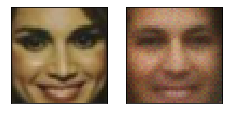

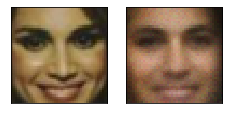

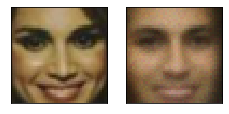

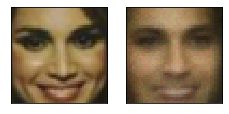

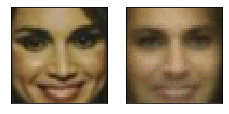

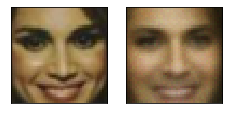

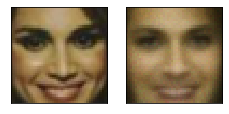

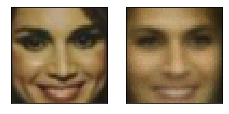

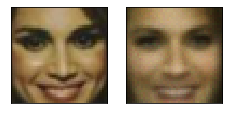

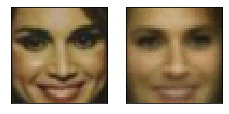

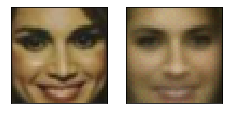

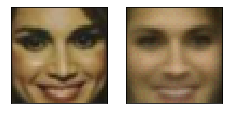

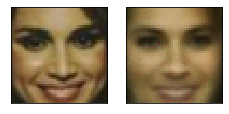

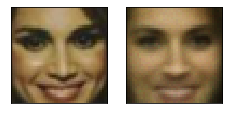

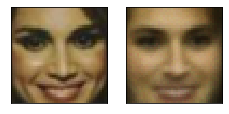

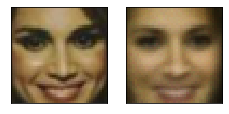

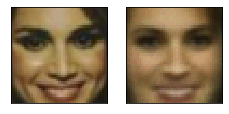

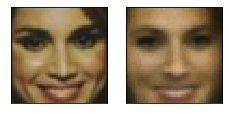

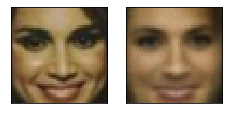

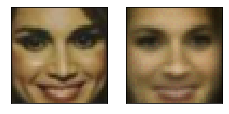

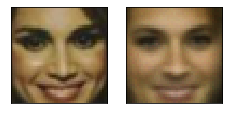

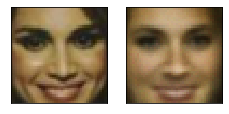

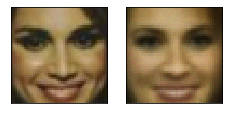

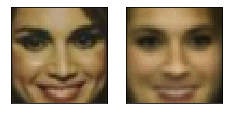

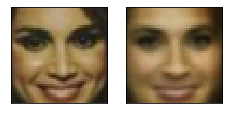

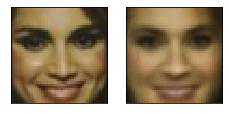

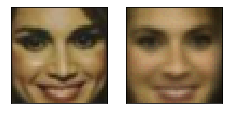

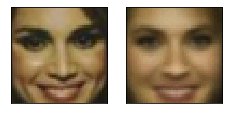

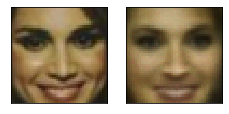

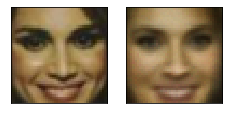

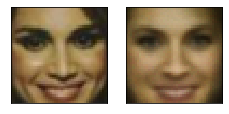

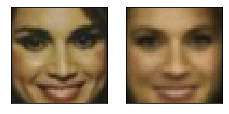

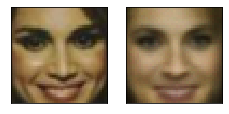

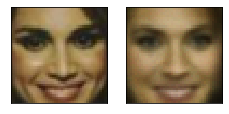

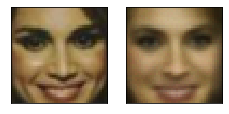

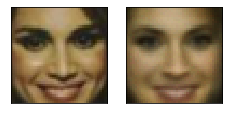

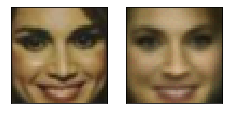

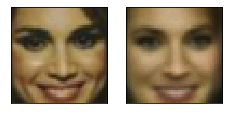

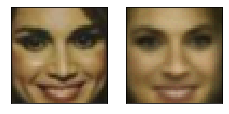

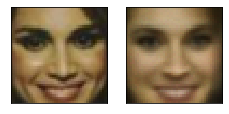

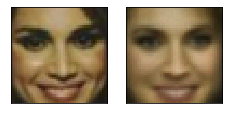

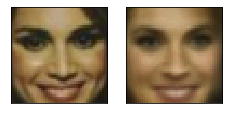

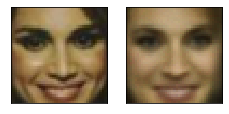

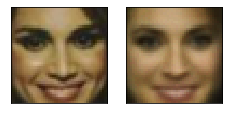

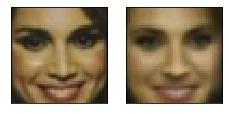

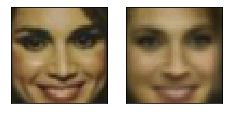

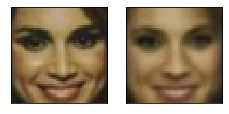

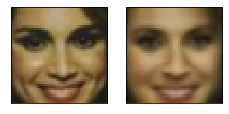

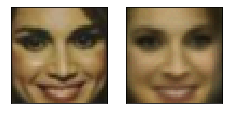

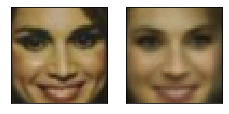

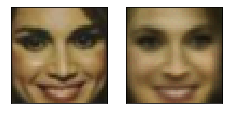

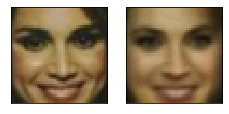

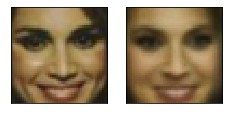

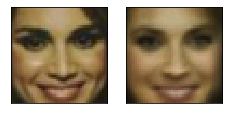

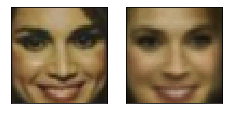

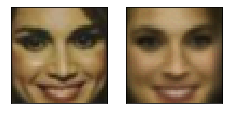

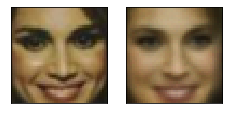

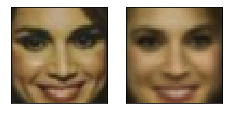

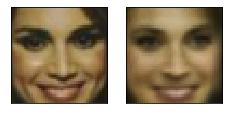

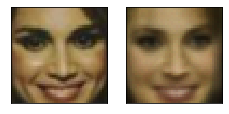

In [ ]:
# Обучаем!
history = train(model=autoencoder, x_train=X_train, x_val=X_val, batches=p_batch_size,\
                epochs=p_epochs, loss_fn=p_loss_fn, optimizer=p_optimizer,\
                scheduler=p_scheduler)

Отобразим train and valid losses на графике.

[]

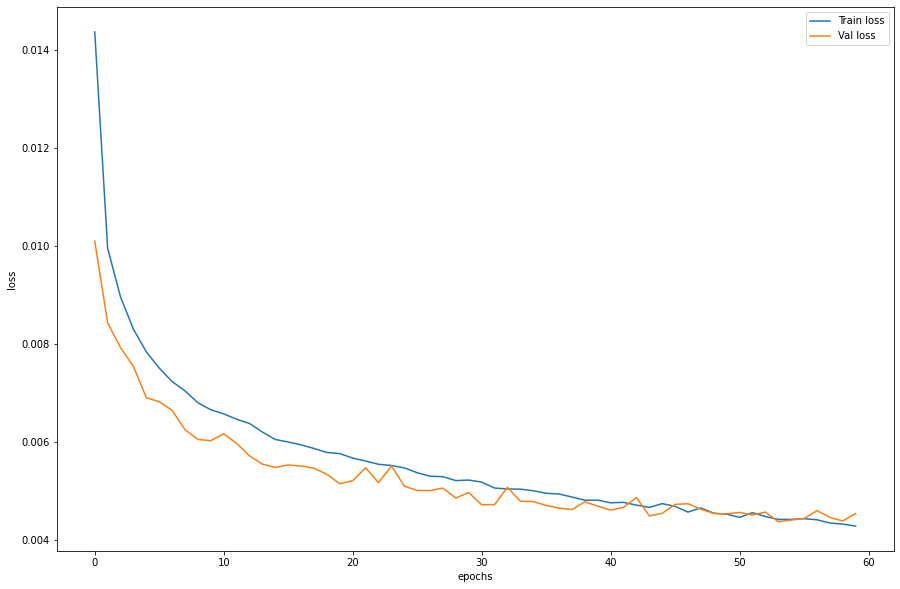

In [ ]:
train_loss, val_loss = zip(*history)
plt.figure(figsize=(15, 10))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot()

По графику видно, что модель стала лучше обучаться начиная с 45 эпохи, значение train loss стало меньшим, чем у valid loss, но при этом оба loss близки друг к другу, нет резких выбросов.

In [ ]:
# Сохраним обученную модель AE
train_loss, val_loss = zip(*history)
ae_file = 'AE_Epochs_{}_Batch_{}_Train_loss_{}_Test_loss_{}.pth'.format(
    p_epochs, p_batch_size, round(train_loss[-1], 4), round(val_loss[-1],4))
torch.save(autoencoder.state_dict(), ae_file)
print("Trained AE model is saved to file:", ae_file)

Trained AE model is saved to file: AE_Epochs_60_Batch_32_Train_loss_0.0043_Test_loss_0.0045.pth


In [ ]:
autoencoder.load_state_dict(torch.load(ae_file))

<All keys matched successfully>

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

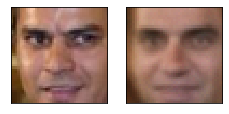

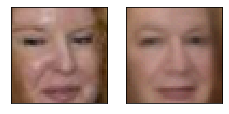

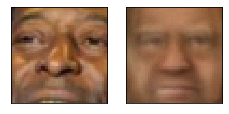

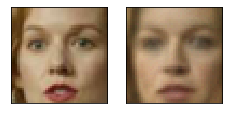

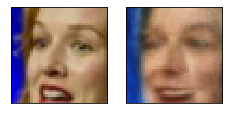

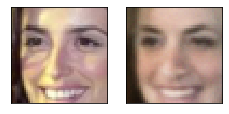

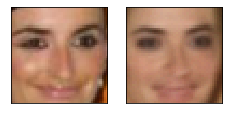

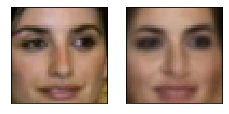

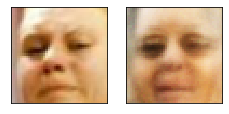

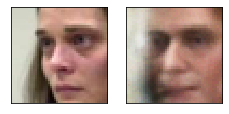

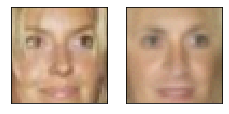

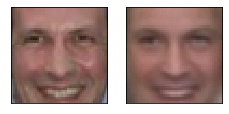

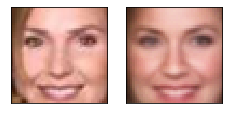

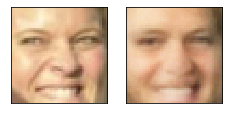

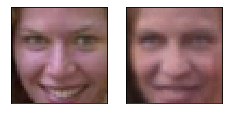

In [ ]:
input_size = 3*45*45
for img in X_val[0:15]:
    with torch.set_grad_enabled(False):
        autoencoder.eval()
        if not is_conv:
            img_input = img.view(-1, input_size)
        else:
            img_input = torch.FloatTensor(img.unsqueeze(0))

        img_input = img_input.cuda()
        recovered_img, latent_img = autoencoder(img_input)
        if not is_conv:
            img_output = recovered_img.view(-1, input_size).squeeze()
        else:
            img_output = recovered_img.permute(0,2,3,1) # возвращаем измерения к исходному виду

        img_output = img_output.cpu()
        img_input  = img_input.cpu()
        # выводим изображени
        plot_gallery([img_input,img_output],45,45,1,2)

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

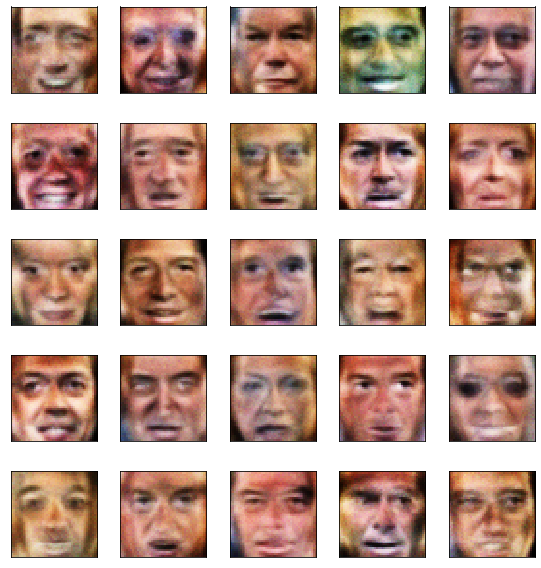

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, 100)

with torch.no_grad():
    inputs = torch.FloatTensor(z)
    autoencoder.eval()
    outputs = autoencoder.decode(inputs.cuda())
    plot_gallery(outputs.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=5, n_col=5)

Я бы сказал, что vanilla автоэнкодер справился с восстановлением картинок. Автоэнкодер справился и с сэмплированием, на картинках все же лица людей, хоть и не красавцы =)
Основные проблемы простого автоэнкодера, то что он сильно воспримичив к переобучению и страдает от затухания градиента.

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
attrs.head()

Male     Asian  ... Wearing Necktie Wearing Necklace
0   1.56835  -1.88904  ...        0.694007        -0.826609
1  0.169851 -0.982408  ...         0.66676        -0.496559
2  0.997749  -1.36419  ...        0.144262        -0.841231
3   1.12272   -1.9978  ...        0.475941        -0.447025
4   1.07821   -2.0081  ...       -0.760774        -0.410152

[5 rows x 73 columns]

In [ ]:
attrs.columns # получим наименование столбцов

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [ ]:
# картинки с улыбающимися людьми
smile_idx = attrs['Smiling'].sort_values(ascending=False).iloc[85:100].index.values
smile_img = data[smile_idx]
# картинки с людьми без улыбки
no_smile_idx = attrs['Smiling'].sort_values(ascending=True).head(15).index.values
no_smile_img = data[no_smile_idx]
# картинки c усатыми людьми
mustache_idx = attrs['Mustache'].sort_values(ascending=False).iloc[5:20].index.values
mustache_img = data[mustache_idx]

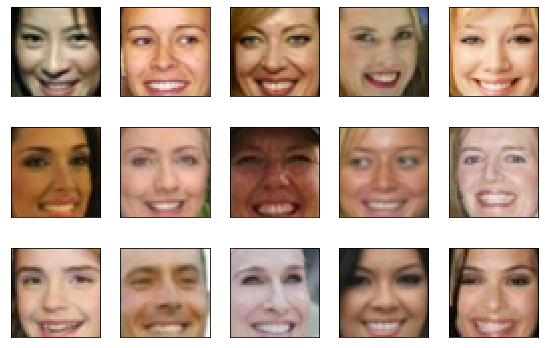

In [ ]:
# выведем улыбашек
plot_gallery(smile_img, IMAGE_H, IMAGE_W, n_row=3, n_col=5)

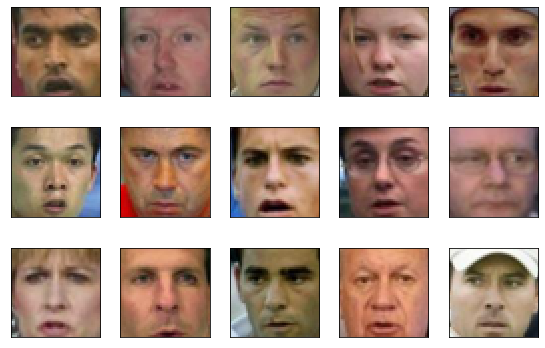

In [ ]:
# выведем грустных
plot_gallery(no_smile_img, IMAGE_H, IMAGE_W, n_row=3, n_col=5)

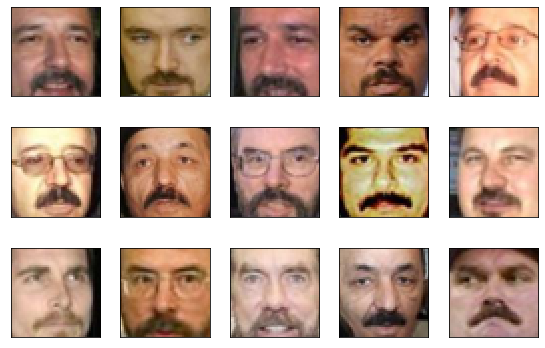

In [ ]:
# выведем усачей
plot_gallery(mustache_img, IMAGE_H, IMAGE_W, n_row=3, n_col=5)

In [ ]:
# функция получения латентного вектора из исходного изображения
def to_latent(pic, model):
        inputs = torch.FloatTensor(pic.reshape(-1, 45*45*3))
        inputs = inputs.cuda()
        model.eval()
        output = model.encode(inputs)        
        return output

# функция получения изображения из заданного латентного вектора
def from_latent(vec, model):
    with torch.no_grad():
        inputs = vec.cuda()
        model.eval()
        output = model.decode(inputs)        
        return output

In [ ]:
# получим латентные вектора для датасетов полученных выше
smile_latent = to_latent(smile_img, autoencoder).mean(axis=0)
no_smile_latent = to_latent(no_smile_img, autoencoder).mean(axis=0)
mustache_latent = to_latent(mustache_img, autoencoder).mean(axis=0)

# посчитаем разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей
smile_vec = smile_latent-no_smile_latent
# посчитаем разность между средним латентным вектором усатых людей и средним латентным вектором веселых людей
mustache_vec = mustache_latent - smile_latent

# функция для добавления улыбки
def make_me_smile(idx):
    for id in idx:
        pic = data[id:id+1]
        latent_vec = to_latent(pic, autoencoder)
        latent_vec[0] += smile_vec
        pic_output = from_latent(latent_vec, autoencoder)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)

# функция для добавления усов
def make_me_mustache(idx):
    for id in idx:
        pic = data[id:id+1]
        latent_vec = to_latent(pic, autoencoder)
        latent_vec[0] += mustache_vec
        pic_output = from_latent(latent_vec, autoencoder)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)

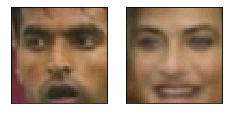

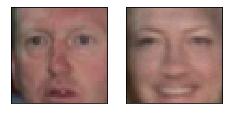

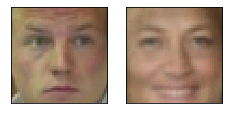

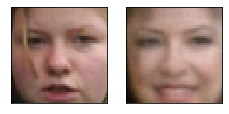

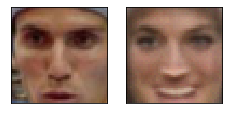

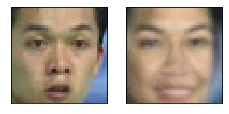

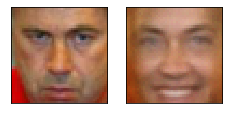

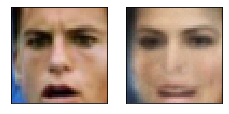

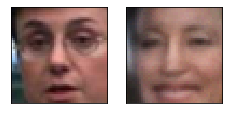

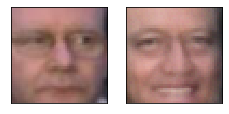

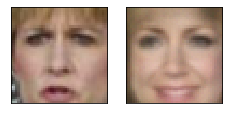

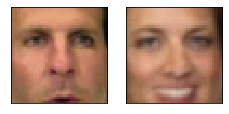

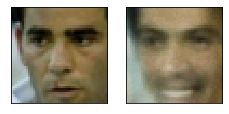

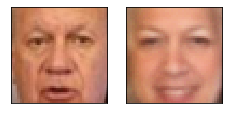

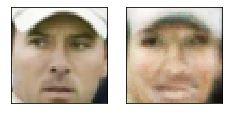

In [ ]:
# Скажите сырррр!
make_me_smile(no_smile_idx)

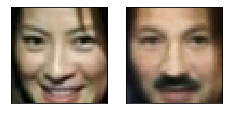

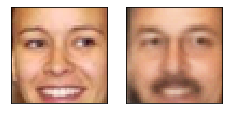

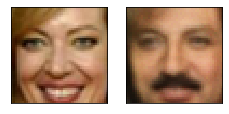

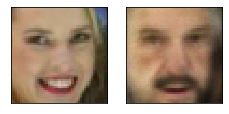

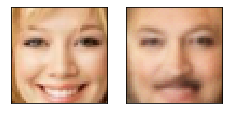

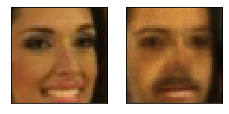

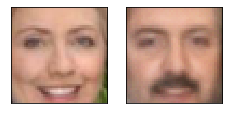

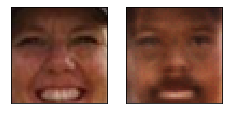

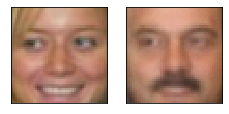

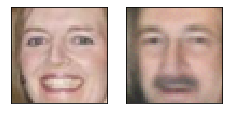

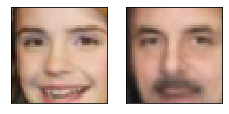

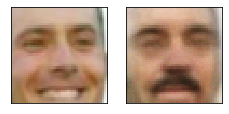

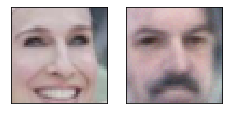

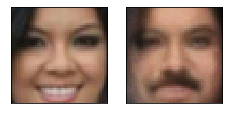

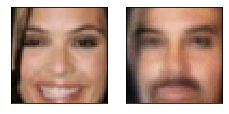

In [ ]:
# Немного поиграем с тестостероном =)
make_me_mustache(smile_idx)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (2 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [ ]:
class VAE(nn.Module):
    def __init__(self, h_dim=1024, z_dim=100):
        super(VAE, self).__init__()
        self.name = "vae"
        self.h_dim = h_dim
        self.z_dim = z_dim

        # слои энкодера
        self.en1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.en_bn1 = nn.BatchNorm2d(32)
        self.en2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.en_bn2 = nn.BatchNorm2d(64)
        self.en3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.en_bn3 = nn.BatchNorm2d(128)
        self.en4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.en_bn4 = nn.BatchNorm2d(256)
        self.en5 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.en_bn5 = nn.BatchNorm2d(256)

        # полносвязанные слои для latent code
        self.fc1 = nn.Linear(self.h_dim, self.z_dim)
        self.fc2 = nn.Linear(self.h_dim, self.z_dim)
        self.fc3 = nn.Linear(self.z_dim, self.h_dim)
        
        # слои декодера
        self.de1 = nn.ConvTranspose2d(self.h_dim, 256, kernel_size=4, stride=3)
        self.de_bn1 = nn.BatchNorm2d(256)
        self.de2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2)
        self.de_bn2 = nn.BatchNorm2d(128)
        self.de3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2)
        self.de_bn3 = nn.BatchNorm2d(64)
        self.de4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2)
        self.de_bn4 = nn.BatchNorm2d(32)
        self.de5 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=1)

        # функции активации
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        # архитектура энкодера
        h1 = self.leakyrelu(self.en1(x))
        h2 = self.leakyrelu(self.en2(h1))
        h3 = self.leakyrelu(self.en3(h2))
        h4 = self.leakyrelu(self.en4(h3))
        h5 = self.leakyrelu(self.en5(h4))
        h5 = h5.contiguous().view(h5.size(0), -1) # конвертируем мномерный тензор в вектор для Linear-слоя
        mu = self.fc1(h5)
        logsigma = self.fc2(h5)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            # std = logsigma.mul(0.5).exp_()
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def get_latent_code(self, x):
        # функция для получения латентного кода из исходного изображения
        mu, logsigma = self.encode(x.view(-1, 3, 45, 45))
        latent_code = self.gaussian_sampler(mu, logsigma)
        return latent_code
    
    def decode(self, z):
        # архитектура декодера
        h1 = self.relu(self.fc3(z))
        h1 = h1.view(h1.size(0), self.h_dim, 1, 1)  # конвертируем вектор в многомерный тензор для ConvTranspose2d слоя
        h2 = self.leakyrelu(self.de_bn1(self.de1(h1)))
        h3 = self.leakyrelu(self.de_bn2(self.de2(h2)))
        h4 = self.leakyrelu(self.de_bn3(self.de3(h3)))
        h5 = self.leakyrelu(self.de_bn4(self.de4(h4)))
        reco = self.sigmoid(self.de5(h5))
        return reco

    def forward(self, x):
        mu, logsigma = self.encode(x.permute(0,3,1,2))
        z = self.gaussian_sampler(mu, logsigma)
        reco = self.decode(z)
        return reco, mu, logsigma

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reco):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = F.binary_cross_entropy(reco, x, size_average=False)
    return loss

def loss_vae(x, reco, mu, logsigma):
    """
    наша VAE loss-функция
    """  
    KLD = KL_divergence(mu, logsigma)
    BCE = log_likelihood(x, reco)
    return BCE + KLD

In [ ]:
is_conv = True
p_loss_fn = loss_vae
model = VAE().cuda()
p_optimizer = optim.Adam(model.parameters(), lr=1e-3)
x_train = X_train[0:1]
train_loader = DataLoader(x_train, batch_size=1)

model.train()
running_loss = 0.0
processed_data = 0

for inputs in train_loader:
    if not is_conv:
        # приводим входной тензор к виду [batch, hight*weight*channel]
        inputs = inputs.view(-1, input_size)
    inputs = inputs.cuda()
    
    optimizer.zero_grad()

    reco, mu, logsigma = model(inputs)
    if not is_conv:
        # приводим входной тензор к виду [batch, hight*weight*channel]
        outputs = reco.view(-1, input_size)
    else:
        # меняем измерения выходного тензора к виду [batch, hight, weight, channel]
        outputs = reco.permute(0,2,3,1)

    loss = loss_fn(inputs, outputs, mu, logsigma)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    processed_data += inputs.size(0)
          
train_loss = running_loss / processed_data

## Train Variational autoencoder (VAE)

In [ ]:
# Training of model
def fit_epoch(model, train_loader, loss_fn, optimizer, input_size=3*45*45, is_conv=False):
    '''
    Обучение выбранной модели
      model        - модель автоэнкодера
      train_loader - тренировачный набор разбитый по batch в DataLoader
      loss_fn      - функция потерь
      optimizer    - функция оптимизации learning rate
      input_size   - кол-во признаков (C_size * H_size * W_size)
    '''
    model.train()
    running_loss = 0.0
    processed_data = 0
  
    for inputs in train_loader:
        if not is_conv:
            # приводим входной тензор к виду [batch, hight*weight*channel]
            inputs = inputs.view(-1, input_size)
        inputs = inputs.cuda()
        
        optimizer.zero_grad()

        reco, mu, logsigma = model(inputs)
        if not is_conv:
            # приводим входной тензор к виду [batch, hight*weight*channel]
            outputs = reco.view(-1, input_size)
        else:
            # меняем измерения выходного тензора к виду [batch, hight, weight, channel]
            outputs = reco.permute(0,2,3,1)

        loss = loss_fn(inputs, outputs, mu, logsigma)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    return train_loss

# Loss estimation
def eval_epoch(model, val_loader, loss_fn, input_size=3*45*45, is_conv=False):
    '''
    Оценка обучаемой модели
      model        - модель автоэнкодера
      val_loader   - проверочный набор разбитый по batch в DataLoader
      loss_fn      - функция потерь
      input_size   - кол-во признаков (C_size * H_size * W_size)
    '''
    model.eval()
    running_loss = 0.0
    processed_size = 0

    for inputs in val_loader:
        if not is_conv:
            # приводим входной тензор к виду [batch, hight*weight*channel]
            inputs = inputs.view(-1, input_size)
        inputs = inputs.cuda()

        with torch.set_grad_enabled(False):
            reco, mu, logsigma = model(inputs)
            if not is_conv:
                # приводим входной тензор к виду [batch, hight*weight*channel]
                outputs = reco.view(-1, input_size)
            else:
                # меняем измерения выходного тензора к виду [batch, hight, weight, channel]
                outputs = reco.permute(0,2,3,1)
            loss = loss_fn(inputs, outputs, mu, logsigma)

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    return val_loss

# STARTER THE TRAINING OF MODEL
def train(model, x_train, x_val, batches, epochs, loss_fn, optimizer, 
          scheduler=None, input_size=3*45*45, log_image=True, is_conv=False):
    '''
    Тренировка модели
      model        - модель автоэнкодера
      train_files  - тренировочная выборка изображений
      val_files    - проверочная выборка изображений
      batches      - кол-во пакетов для разбивки изображений
      epochs       - кол-во эпох
      loss_fn      - функция потерь
      optimizer    - оптимизатор learning rate
      scheduler    - планировщик для оптимизации learning rate
      input_size   - (если FC-слой на входе) кол-во признаков (C_size * H_size * W_size)
      log_image    - (True) выводить восстановленное и латентное изображения
      is_conv      - (False) сверточная архитектура сети
    '''
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"

    # Перемешиваем и разбиваем тренировочный набор по батчам
    train_loader = DataLoader(x_train, batch_size=batches, shuffle=True,
                              num_workers=2)
    # Разбиваем валидационный набор по батчам
    val_loader   = DataLoader(x_val, batch_size=batches, shuffle=False, 
                              num_workers=2)

    # отображаем прогресс обучения модели
    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            # обучаем модель на тренировочной выборке
            train_loss = fit_epoch(model, train_loader, loss_fn, 
                                   optimizer, input_size, is_conv)
            # оцениваем модель на валидационной выборке
            val_loss = eval_epoch(model, val_loader, loss_fn, input_size, 
                                  is_conv)
            # логгируем потери
            history.append((train_loss, val_loss))
            if scheduler != None:
                # запускаем планировщик для регулировки learning rate
                scheduler.step(val_loss)

            # выводим на каждой эпохе восстановленное изображение и его латентный вектор
            if log_image:
                with torch.set_grad_enabled(False):
                    model.eval()
                    img = x_val[279]
                    if not is_conv:
                        # приводим тензор картинки к виду [batch, hight*weight*channel]
                        img_input = img.view(-1, input_size)
                    else:
                        # приводим тензор входной картинки к виду [1, channel, hight, weight]
                        img_input = torch.FloatTensor(img.unsqueeze(0))

                    img_input = img_input.cuda()
                    reco_img, mu, logsigma = model(img_input)
                    
                    if not is_conv:
                        # приводим тензор восстановленной картинки к виду [batch, hight*weight*channel]
                        img_output = reco_img.view(-1, input_size).squeeze()
                    else:
                        # приводим тензор восстановленной картинки к виду [1, hight, weight, channel]
                        img_output = reco_img.permute(0,2,3,1)

                    img_output = img_output.cpu()
                    img_input  = img_input.cpu()
                    # выводим изображение
                    plot_gallery([img_input, img_output],45,45,1,2)

            # Обновляем индикатор прогресса обучения модели
            pbar_outer.update(1)
            # Выводим сообщение через tqdm
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss))
           
    return history

In [ ]:
# Гиперпараметры
p_epochs = 80
p_batch_size = 32
is_conv=True

p_loss_fn = loss_vae
autoencoder_vae = VAE()
# p_optimizer = optim.RMSprop(autoencoder_vae.parameters(), lr=1e-3)
p_optimizer = optim.Adam(autoencoder_vae.parameters(), lr=1e-4)
p_scheduler=None
autoencoder_vae = autoencoder_vae.cuda()

epoch:   1%|          | 1/100 [00:04<07:44,  4.70s/it]


Epoch 001 train_loss: 251978.2008 val_loss 255065.1946


epoch:   2%|▏         | 2/100 [00:09<07:40,  4.70s/it]


Epoch 002 train_loss: 244868.0194 val_loss 244479.0044


epoch:   3%|▎         | 3/100 [00:14<07:42,  4.76s/it]


Epoch 003 train_loss: 242846.3296 val_loss 241128.9849


epoch:   4%|▍         | 4/100 [00:19<07:35,  4.74s/it]


Epoch 004 train_loss: 242168.3037 val_loss 241021.6913


epoch:   5%|▌         | 5/100 [00:23<07:29,  4.73s/it]


Epoch 005 train_loss: 241655.1355 val_loss 240337.1277


epoch:   6%|▌         | 6/100 [00:28<07:23,  4.72s/it]


Epoch 006 train_loss: 241197.9061 val_loss 239877.5716


epoch:   7%|▋         | 7/100 [00:33<07:17,  4.71s/it]


Epoch 007 train_loss: 240908.5566 val_loss 240725.8209


epoch:   8%|▊         | 8/100 [00:37<07:12,  4.70s/it]


Epoch 008 train_loss: 240456.4749 val_loss 239331.2950


epoch:   9%|▉         | 9/100 [00:42<07:07,  4.70s/it]


Epoch 009 train_loss: 240111.7195 val_loss 238747.4308


epoch:  10%|█         | 10/100 [00:47<07:01,  4.69s/it]


Epoch 010 train_loss: 239872.5124 val_loss 238461.7022


epoch:  11%|█         | 11/100 [00:51<06:57,  4.69s/it]


Epoch 011 train_loss: 239703.5425 val_loss 238338.6509


epoch:  12%|█▏        | 12/100 [00:56<06:53,  4.70s/it]


Epoch 012 train_loss: 239484.0489 val_loss 238294.3363


epoch:  13%|█▎        | 13/100 [01:01<06:48,  4.69s/it]


Epoch 013 train_loss: 239413.4138 val_loss 238028.9588


epoch:  14%|█▍        | 14/100 [01:05<06:43,  4.69s/it]


Epoch 014 train_loss: 239313.3131 val_loss 238788.4570


epoch:  15%|█▌        | 15/100 [01:10<06:38,  4.69s/it]


Epoch 015 train_loss: 239190.7565 val_loss 238721.2002


epoch:  16%|█▌        | 16/100 [01:15<06:34,  4.70s/it]


Epoch 016 train_loss: 239109.8218 val_loss 238129.8634


epoch:  17%|█▋        | 17/100 [01:19<06:29,  4.69s/it]


Epoch 017 train_loss: 239004.8581 val_loss 238195.4661


epoch:  18%|█▊        | 18/100 [01:24<06:24,  4.69s/it]


Epoch 018 train_loss: 238994.0410 val_loss 237823.2116


epoch:  19%|█▉        | 19/100 [01:29<06:20,  4.70s/it]


Epoch 019 train_loss: 238866.7252 val_loss 237625.0852


epoch:  20%|██        | 20/100 [01:34<06:16,  4.70s/it]


Epoch 020 train_loss: 238765.3376 val_loss 238024.9975


epoch:  21%|██        | 21/100 [01:38<06:11,  4.70s/it]


Epoch 021 train_loss: 238776.1578 val_loss 237882.5712


epoch:  22%|██▏       | 22/100 [01:43<06:07,  4.71s/it]


Epoch 022 train_loss: 238744.6737 val_loss 237667.4849


epoch:  23%|██▎       | 23/100 [01:48<06:02,  4.70s/it]


Epoch 023 train_loss: 238669.3532 val_loss 237365.1154


epoch:  24%|██▍       | 24/100 [01:52<05:56,  4.70s/it]


Epoch 024 train_loss: 238599.7645 val_loss 237830.8364


epoch:  25%|██▌       | 25/100 [01:57<05:52,  4.70s/it]


Epoch 025 train_loss: 238558.8100 val_loss 237836.3790


epoch:  26%|██▌       | 26/100 [02:02<05:47,  4.70s/it]


Epoch 026 train_loss: 238459.7584 val_loss 237396.0419


epoch:  27%|██▋       | 27/100 [02:06<05:42,  4.69s/it]


Epoch 027 train_loss: 238436.0962 val_loss 237651.3194


epoch:  28%|██▊       | 28/100 [02:11<05:37,  4.69s/it]


Epoch 028 train_loss: 238458.9878 val_loss 237552.0309


epoch:  29%|██▉       | 29/100 [02:16<05:34,  4.71s/it]


Epoch 029 train_loss: 238438.2688 val_loss 237451.3730


epoch:  30%|███       | 30/100 [02:21<05:29,  4.70s/it]


Epoch 030 train_loss: 238404.1706 val_loss 237342.1409


epoch:  31%|███       | 31/100 [02:25<05:24,  4.70s/it]


Epoch 031 train_loss: 238412.0868 val_loss 237227.6075


epoch:  32%|███▏      | 32/100 [02:30<05:19,  4.70s/it]


Epoch 032 train_loss: 238335.4619 val_loss 237811.8044


epoch:  33%|███▎      | 33/100 [02:35<05:15,  4.71s/it]


Epoch 033 train_loss: 238322.3411 val_loss 237574.4865


epoch:  34%|███▍      | 34/100 [02:39<05:10,  4.71s/it]


Epoch 034 train_loss: 238236.5539 val_loss 237467.9026


epoch:  35%|███▌      | 35/100 [02:44<05:05,  4.70s/it]


Epoch 035 train_loss: 238169.2724 val_loss 237169.3632


epoch:  36%|███▌      | 36/100 [02:49<05:00,  4.70s/it]


Epoch 036 train_loss: 238182.1853 val_loss 237637.8874


epoch:  37%|███▋      | 37/100 [02:54<04:55,  4.70s/it]


Epoch 037 train_loss: 238154.9772 val_loss 237143.2694


epoch:  38%|███▊      | 38/100 [02:58<04:51,  4.69s/it]


Epoch 038 train_loss: 238138.7693 val_loss 237571.4355


epoch:  39%|███▉      | 39/100 [03:03<04:46,  4.70s/it]


Epoch 039 train_loss: 238095.2467 val_loss 237494.0493


epoch:  40%|████      | 40/100 [03:08<04:42,  4.70s/it]


Epoch 040 train_loss: 238015.6996 val_loss 237232.4521


epoch:  41%|████      | 41/100 [03:12<04:37,  4.70s/it]


Epoch 041 train_loss: 238028.7711 val_loss 237272.9998


epoch:  42%|████▏     | 42/100 [03:17<04:32,  4.70s/it]


Epoch 042 train_loss: 237956.2976 val_loss 237193.1609


epoch:  43%|████▎     | 43/100 [03:22<04:27,  4.69s/it]


Epoch 043 train_loss: 237893.4232 val_loss 237352.6688


epoch:  44%|████▍     | 44/100 [03:26<04:22,  4.69s/it]


Epoch 044 train_loss: 238000.9840 val_loss 237166.5924


epoch:  45%|████▌     | 45/100 [03:31<04:18,  4.70s/it]


Epoch 045 train_loss: 237899.3053 val_loss 237408.6039


epoch:  46%|████▌     | 46/100 [03:36<04:13,  4.69s/it]


Epoch 046 train_loss: 237880.6747 val_loss 237205.4169


epoch:  47%|████▋     | 47/100 [03:40<04:08,  4.69s/it]


Epoch 047 train_loss: 237864.8403 val_loss 237389.6677


epoch:  48%|████▊     | 48/100 [03:45<04:04,  4.69s/it]


Epoch 048 train_loss: 237797.1497 val_loss 237313.7772


epoch:  49%|████▉     | 49/100 [03:50<03:59,  4.69s/it]


Epoch 049 train_loss: 237888.8964 val_loss 237182.8125


epoch:  50%|█████     | 50/100 [03:55<03:54,  4.69s/it]


Epoch 050 train_loss: 237705.8803 val_loss 237319.5659


epoch:  51%|█████     | 51/100 [03:59<03:49,  4.69s/it]


Epoch 051 train_loss: 237744.8319 val_loss 237331.3556


epoch:  52%|█████▏    | 52/100 [04:04<03:45,  4.69s/it]


Epoch 052 train_loss: 237667.8663 val_loss 237100.1641


epoch:  53%|█████▎    | 53/100 [04:09<03:40,  4.69s/it]


Epoch 053 train_loss: 237633.1942 val_loss 237222.5226


epoch:  54%|█████▍    | 54/100 [04:13<03:35,  4.69s/it]


Epoch 054 train_loss: 237640.3992 val_loss 237662.9567


epoch:  55%|█████▌    | 55/100 [04:18<03:33,  4.73s/it]


Epoch 055 train_loss: 237641.2371 val_loss 237527.5056


epoch:  56%|█████▌    | 56/100 [04:23<03:27,  4.72s/it]


Epoch 056 train_loss: 237610.1876 val_loss 237157.5927


epoch:  57%|█████▋    | 57/100 [04:28<03:22,  4.71s/it]


Epoch 057 train_loss: 237529.1535 val_loss 237095.3686


epoch:  58%|█████▊    | 58/100 [04:32<03:17,  4.71s/it]


Epoch 058 train_loss: 237588.1306 val_loss 237704.5620


epoch:  59%|█████▉    | 59/100 [04:37<03:12,  4.70s/it]


Epoch 059 train_loss: 237557.4761 val_loss 237215.8741


epoch:  60%|██████    | 60/100 [04:42<03:08,  4.70s/it]


Epoch 060 train_loss: 237513.2019 val_loss 237295.2269


epoch:  61%|██████    | 61/100 [04:46<03:03,  4.70s/it]


Epoch 061 train_loss: 237448.0460 val_loss 237291.9906


epoch:  62%|██████▏   | 62/100 [04:51<02:58,  4.69s/it]


Epoch 062 train_loss: 237441.5329 val_loss 237467.1023


epoch:  63%|██████▎   | 63/100 [04:56<02:53,  4.69s/it]


Epoch 063 train_loss: 237457.0595 val_loss 237285.3464


epoch:  64%|██████▍   | 64/100 [05:00<02:48,  4.69s/it]


Epoch 064 train_loss: 237396.2559 val_loss 237447.2677


epoch:  65%|██████▌   | 65/100 [05:05<02:44,  4.69s/it]


Epoch 065 train_loss: 237380.2321 val_loss 237322.9622


epoch:  66%|██████▌   | 66/100 [05:10<02:39,  4.68s/it]


Epoch 066 train_loss: 237356.1234 val_loss 238937.4840


epoch:  67%|██████▋   | 67/100 [05:14<02:34,  4.69s/it]


Epoch 067 train_loss: 237301.1675 val_loss 238855.5778


epoch:  68%|██████▊   | 68/100 [05:19<02:29,  4.68s/it]


Epoch 068 train_loss: 237355.4353 val_loss 237219.0447


epoch:  69%|██████▉   | 69/100 [05:24<02:24,  4.67s/it]


Epoch 069 train_loss: 237266.9057 val_loss 237679.8771


epoch:  70%|███████   | 70/100 [05:28<02:20,  4.68s/it]


Epoch 070 train_loss: 237272.5131 val_loss 237418.7007


epoch:  71%|███████   | 71/100 [05:33<02:15,  4.68s/it]


Epoch 071 train_loss: 237240.6221 val_loss 237425.6398


epoch:  72%|███████▏  | 72/100 [05:38<02:11,  4.68s/it]


Epoch 072 train_loss: 237193.5853 val_loss 237491.7413


epoch:  73%|███████▎  | 73/100 [05:42<02:06,  4.69s/it]


Epoch 073 train_loss: 237151.6381 val_loss 237375.1436


epoch:  74%|███████▍  | 74/100 [05:47<02:01,  4.69s/it]


Epoch 074 train_loss: 237175.9021 val_loss 237475.2912


epoch:  75%|███████▌  | 75/100 [05:52<01:57,  4.68s/it]


Epoch 075 train_loss: 237195.3991 val_loss 237298.8255


epoch:  76%|███████▌  | 76/100 [05:57<01:52,  4.68s/it]


Epoch 076 train_loss: 237124.6900 val_loss 237358.7255


epoch:  77%|███████▋  | 77/100 [06:01<01:47,  4.69s/it]


Epoch 077 train_loss: 237083.7004 val_loss 237652.5323


epoch:  78%|███████▊  | 78/100 [06:06<01:43,  4.68s/it]


Epoch 078 train_loss: 237045.9300 val_loss 237329.7076


epoch:  79%|███████▉  | 79/100 [06:11<01:38,  4.69s/it]


Epoch 079 train_loss: 237034.7336 val_loss 237426.9404


epoch:  80%|████████  | 80/100 [06:15<01:33,  4.69s/it]


Epoch 080 train_loss: 237013.6553 val_loss 237386.5433


epoch:  81%|████████  | 81/100 [06:20<01:29,  4.68s/it]


Epoch 081 train_loss: 237012.7905 val_loss 237426.4883


epoch:  82%|████████▏ | 82/100 [06:25<01:24,  4.69s/it]


Epoch 082 train_loss: 236971.8005 val_loss 237515.7266


epoch:  83%|████████▎ | 83/100 [06:29<01:20,  4.73s/it]


Epoch 083 train_loss: 236975.1208 val_loss 237613.0215


epoch:  84%|████████▍ | 84/100 [06:34<01:15,  4.72s/it]


Epoch 084 train_loss: 236928.7226 val_loss 237444.2167


epoch:  85%|████████▌ | 85/100 [06:39<01:10,  4.71s/it]


Epoch 085 train_loss: 236889.6974 val_loss 238015.9982


epoch:  86%|████████▌ | 86/100 [06:44<01:05,  4.71s/it]


Epoch 086 train_loss: 236922.9372 val_loss 237901.3599


epoch:  87%|████████▋ | 87/100 [06:48<01:01,  4.71s/it]


Epoch 087 train_loss: 236885.7793 val_loss 238270.9797


epoch:  88%|████████▊ | 88/100 [06:53<00:56,  4.70s/it]


Epoch 088 train_loss: 236852.9545 val_loss 237406.0966


epoch:  89%|████████▉ | 89/100 [06:58<00:51,  4.70s/it]


Epoch 089 train_loss: 236826.8528 val_loss 237407.1309


epoch:  90%|█████████ | 90/100 [07:02<00:47,  4.70s/it]


Epoch 090 train_loss: 236800.5905 val_loss 237535.8542


epoch:  91%|█████████ | 91/100 [07:07<00:42,  4.71s/it]


Epoch 091 train_loss: 236756.5422 val_loss 237666.3137


epoch:  92%|█████████▏| 92/100 [07:12<00:37,  4.70s/it]


Epoch 092 train_loss: 236762.3940 val_loss 237520.5627


epoch:  93%|█████████▎| 93/100 [07:16<00:32,  4.70s/it]


Epoch 093 train_loss: 236752.8514 val_loss 237483.8162


epoch:  94%|█████████▍| 94/100 [07:21<00:28,  4.70s/it]


Epoch 094 train_loss: 236711.0497 val_loss 237410.2073


epoch:  95%|█████████▌| 95/100 [07:26<00:23,  4.70s/it]


Epoch 095 train_loss: 236696.1855 val_loss 237881.1605


epoch:  96%|█████████▌| 96/100 [07:31<00:18,  4.70s/it]


Epoch 096 train_loss: 236687.2217 val_loss 237886.3172


epoch:  97%|█████████▋| 97/100 [07:35<00:14,  4.70s/it]


Epoch 097 train_loss: 236691.0808 val_loss 237475.2020


epoch:  98%|█████████▊| 98/100 [07:40<00:09,  4.70s/it]


Epoch 098 train_loss: 236669.7320 val_loss 237644.3021


epoch:  99%|█████████▉| 99/100 [07:45<00:04,  4.71s/it]


Epoch 099 train_loss: 236647.2208 val_loss 237435.3382


epoch: 100%|██████████| 100/100 [07:49<00:00,  4.70s/it]



Epoch 100 train_loss: 236663.5731 val_loss 238164.6691


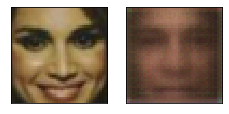

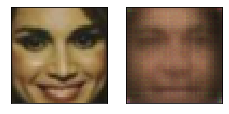

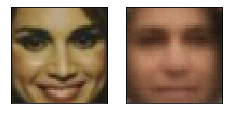

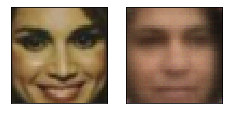

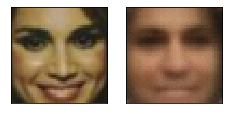

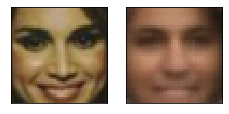

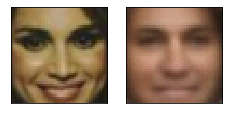

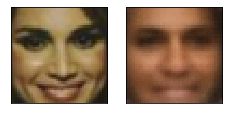

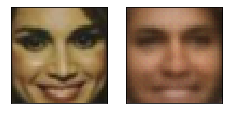

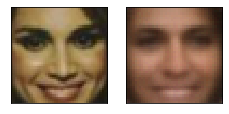

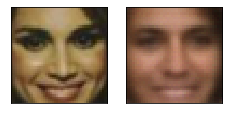

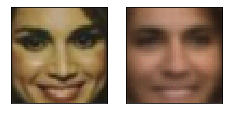

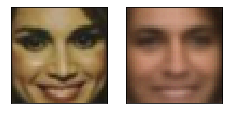

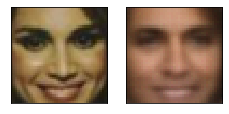

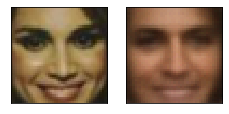

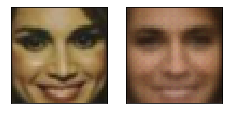

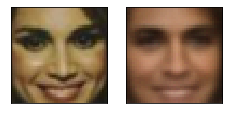

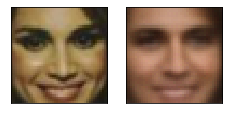

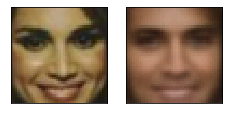

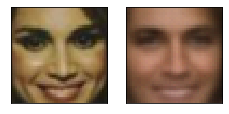

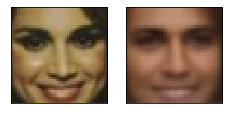

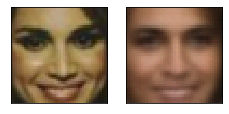

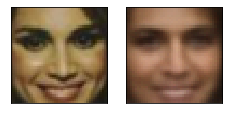

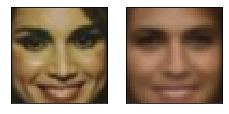

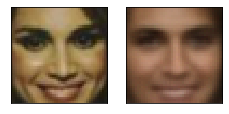

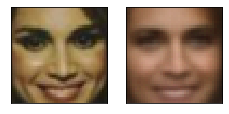

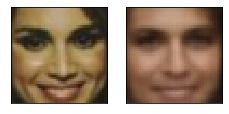

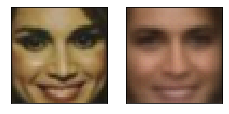

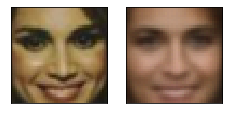

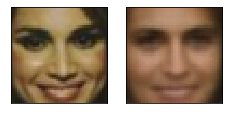

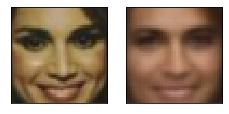

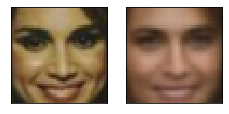

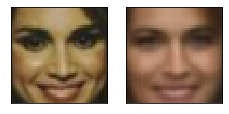

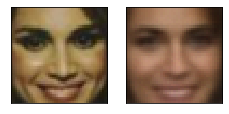

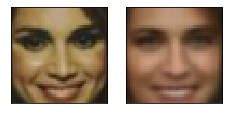

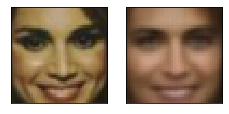

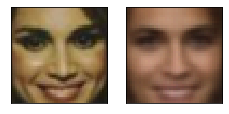

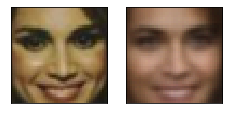

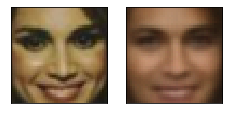

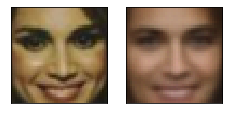

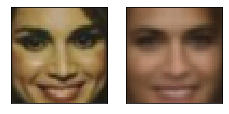

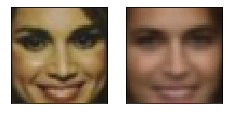

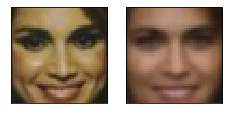

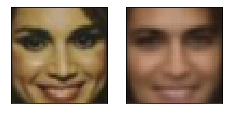

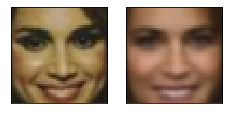

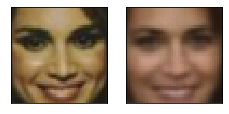

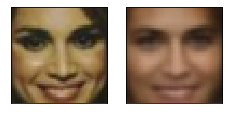

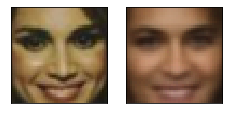

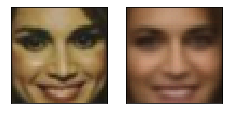

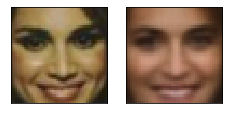

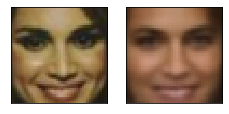

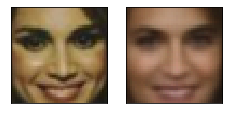

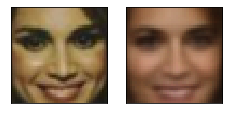

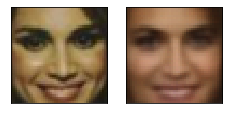

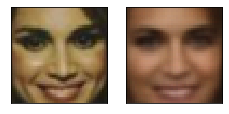

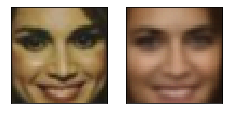

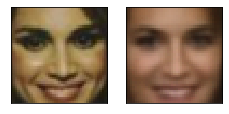

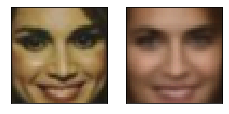

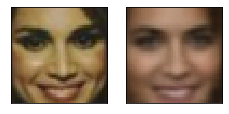

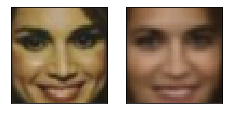

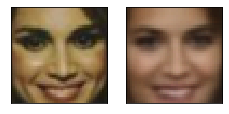

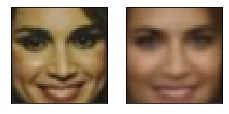

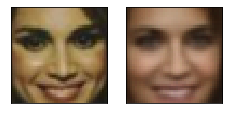

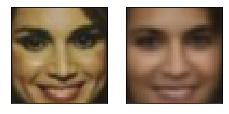

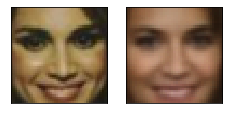

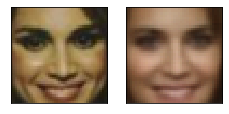

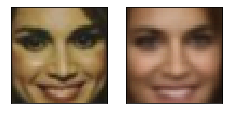

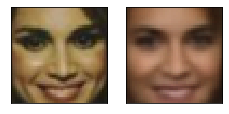

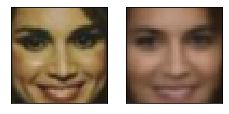

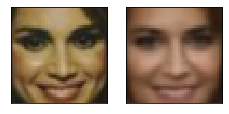

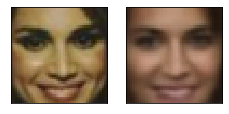

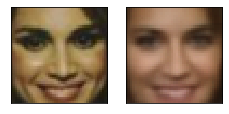

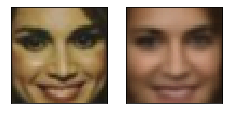

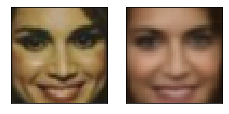

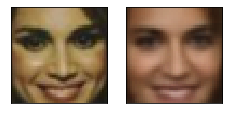

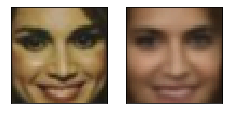

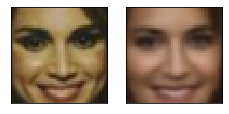

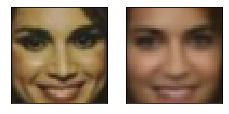

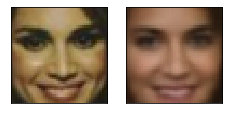

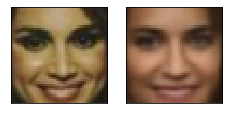

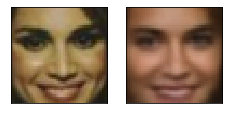

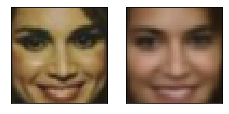

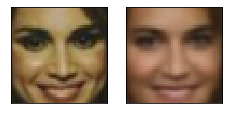

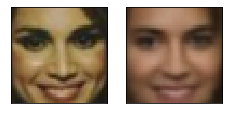

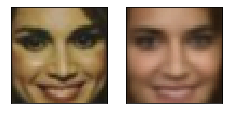

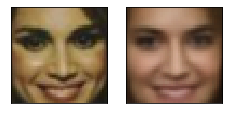

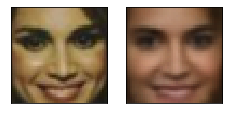

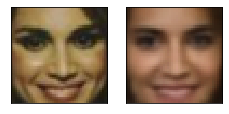

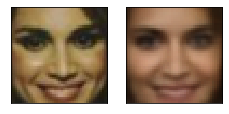

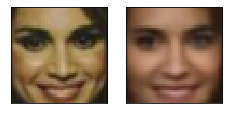

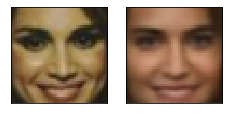

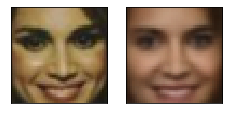

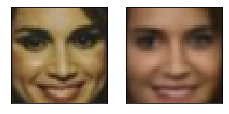

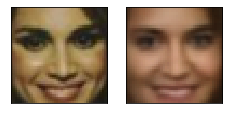

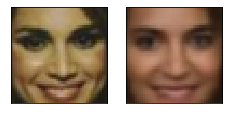

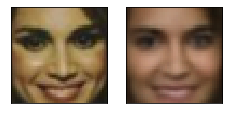

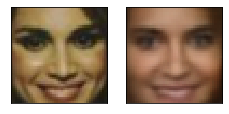

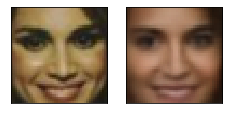

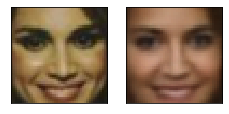

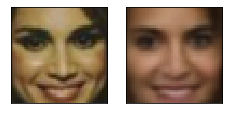

In [ ]:
# Обучаем!
history_vae = train(model=autoencoder_vae, x_train=X_train, x_val=X_val, batches=p_batch_size,\
                epochs=p_epochs, loss_fn=p_loss_fn, optimizer=p_optimizer,\
                scheduler=p_scheduler, is_conv=is_conv)

In [ ]:
# Сохраним обученную модель VAE
train_loss, val_loss = zip(*history_vae)
vae_file = 'VAE_Epochs_{}_Batch_{}_Train_loss_{}_Test_loss_{}.pth'.format(
    p_epochs, p_batch_size, round(train_loss[-1], 4), round(val_loss[-1],4))
torch.save(autoencoder_vae.state_dict(), vae_file)
print("Trained VAE model is saved to file:", vae_file)

Trained VAE model is saved to file: VAE_Epochs_100_Batch_64_Train_loss_236663.5731_Test_loss_238164.6691.pth


In [ ]:
autoencoder_vae.load_state_dict(torch.load(vae_file))

Посмотрим train and valid losses на графике.

[]

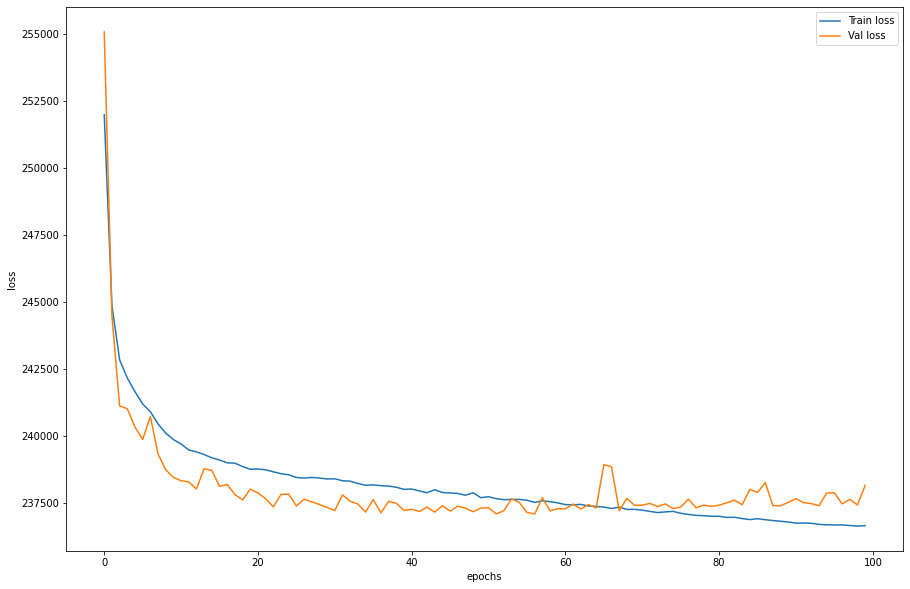

In [ ]:
train_loss, val_loss = zip(*history_vae)
plt.figure(figsize=(15, 10))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

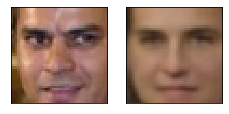

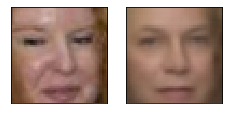

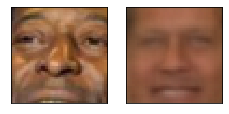

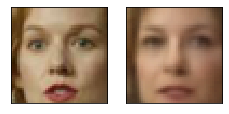

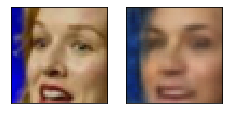

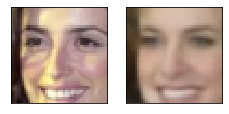

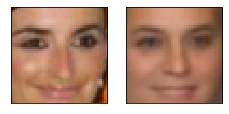

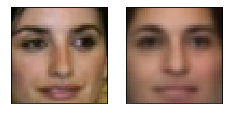

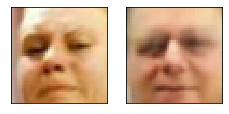

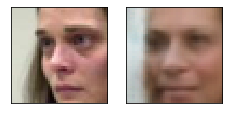

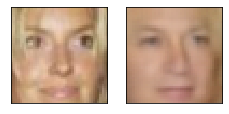

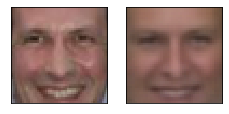

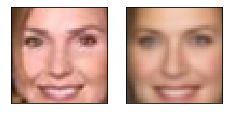

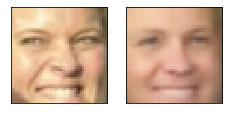

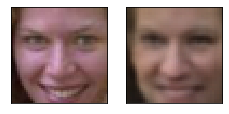

In [ ]:
input_size = 3*45*45
for img in X_val[0:15]:
  with torch.set_grad_enabled(False):
      autoencoder_vae.eval()
      if not is_conv:
          img_input = img.view(-1, input_size)
      else:
          img_input = torch.FloatTensor(img.unsqueeze(0))

      img_input = img_input.cuda()
      reco, mu, logsigma = autoencoder_vae(img_input)

      if not is_conv:
          img_output = reco.view(-1, input_size).squeeze()
      else:
          img_output = reco.permute(0,2,3,1) # возвращаем измерения к исходному виду

      img_output = img_output.cpu()
      img_input  = img_input.cpu()
      # выводим изображени
      plot_gallery([img_input,img_output],45,45,1,2)

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

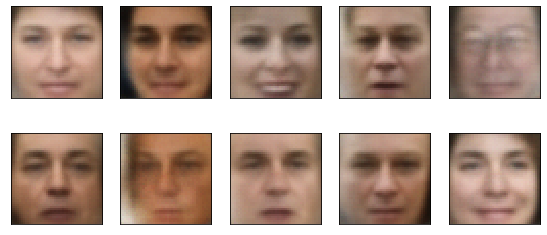

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
with torch.no_grad():
    inputs = torch.FloatTensor(z)
    autoencoder_vae.eval()
    output = autoencoder_vae.decode(inputs.cuda())
    output = output.permute(0,2,3,1)
    plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=2, n_col=5)

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [ ]:
import sklearn
from sklearn.manifold import TSNE
# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

laten_list = []
x_test = X_val[0:15]
with torch.set_grad_enabled(False):
    for img in x_test:
        autoencoder_vae.eval()
        if not is_conv:
            img_input = img.view(-1, input_size)
        else:
            img_input = torch.FloatTensor(img.unsqueeze(0))

        img_input = img_input.cuda()
        latent_code = autoencoder_vae.get_latent_code(img_input)
        print(latent_code.shape)
        laten_list.append(latent_code)
        X = torch.cat(laten_list, dim=0)
    res = TSNE(random_state=42).fit_transform(X.data.cpu().numpy())
    print(res.shape)


y = np.hstack([x_test[x_test==i]
               for i in range(10)])
palette = np.array(sns.color_palette("hls", 10))
plt.figure(figsize=(6, 6))
plt.scatter(res[:, 0], res[:, 1], c=palette[colors.astype(np.int)])
plt.colorbar()
plt.show()

In [ ]:
attr_idx = attrs.iloc[10000:10015].index.values
attr_img = data[attr_idx]

In [ ]:
attr_img

array([[[[0.28627452, 0.16078432, 0.05098039],
         [0.29411766, 0.19215687, 0.09411765],
         [0.3137255 , 0.21960784, 0.13333334],
         ...,
         [0.5411765 , 0.3647059 , 0.26666668],
         [0.5019608 , 0.34509805, 0.2509804 ],
         [0.4627451 , 0.3254902 , 0.24313726]],

        [[0.32941177, 0.20392157, 0.09803922],
         [0.30980393, 0.20784314, 0.11372549],
         [0.3372549 , 0.23921569, 0.15294118],
         ...,
         [0.53333336, 0.36078432, 0.25490198],
         [0.5019608 , 0.3372549 , 0.24705882],
         [0.45882353, 0.3137255 , 0.23529412]],

        [[0.38431373, 0.2627451 , 0.15294118],
         [0.31764707, 0.21960784, 0.12156863],
         [0.3372549 , 0.23529412, 0.15294118],
         ...,
         [0.53333336, 0.36078432, 0.24313726],
         [0.50980395, 0.34901962, 0.24705882],
         [0.48235294, 0.33333334, 0.2509804 ]],

        ...,

        [[0.24705882, 0.14509805, 0.05098039],
         [0.2509804 , 0.14901961, 0.04705882]

Что вы думаете о виде латентного представления?

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [ ]:
<тут ваш код объявления CVAE, лосса, оптимизатора и тренировки>

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

In [ ]:
<тут нужно научиться сэмплировать из декодера цифры определенного класса>

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [ ]:
<тут ваш код>

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [ ]:
<тут ваш код обучения автоэнкодера на occluded (простите, не знаю, как это сказать по-русски) картинках. Не забудтье разбить на train/test!>

# Bonus 3: Image Retrieval (2 балла)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!